In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit,RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import learning_curve,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import argparse
import graphviz

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Loading Data and model

In [3]:
# Load the cancer data set, and then divide the training set and test set, 
# 75% of the data is used as the training set, and the remaining 25% is used as the test set
print("[INFO] loading data...")
dataset = load_breast_cancer() 
(trainX, testX, trainY, testY) = train_test_split(dataset.data, dataset.target, random_state=3, test_size=0.25)

[INFO] loading data...


# Hyperparameter Tuning

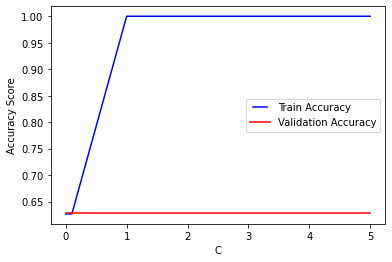

In [4]:
C = [0.00001,0.0001,0.001, 0.01,0.1,1,5]
train_results = []
test_results = []

for c in C:
    clf = SVC(C=c, gamma='auto', probability=True, tol=0.01)
    clf.fit(trainX, trainY)
    train_pred = clf.predict(trainX)
    train_results.append(accuracy_score(trainY, train_pred))
    
    y_pred = clf.predict(testX)
    test_results.append(accuracy_score(testY, y_pred))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(C, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(C, test_results, 'r', label="Validation Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy Score")
plt.xlabel("C")
plt.show()

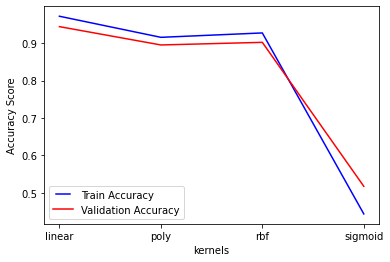

In [5]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_results = []
test_results = []

for kernel in kernels:
    clf = SVC(kernel=kernel)
    clf.fit(trainX, trainY)
    train_pred = clf.predict(trainX)
    train_results.append(accuracy_score(trainY, train_pred))
    
    y_pred = clf.predict(testX)
    test_results.append(accuracy_score(testY, y_pred))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(kernels, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(kernels, test_results, 'r', label="Validation Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy Score")
plt.xlabel("kernels")
plt.show()

In [6]:
model = SVC(kernel="linear", gamma="auto",C=0.1).fit(trainX, trainY)

Text(0.5, 1.0, 'Support Vector Classifier on glass data')

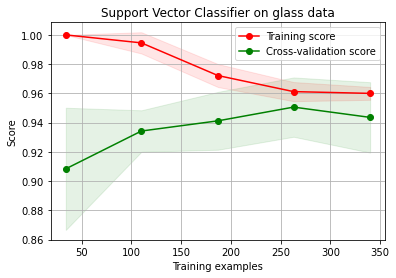

In [7]:
# learning curve
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, trainX, trainY, cv=5,train_sizes=np.linspace(.1, 1.0, 5),return_times=True)

fit_times_mean = np.mean(fit_times,axis = 1)
fit_times_std = np.std(fit_times,axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Support Vector Classifier on glass data")

# Model implementation

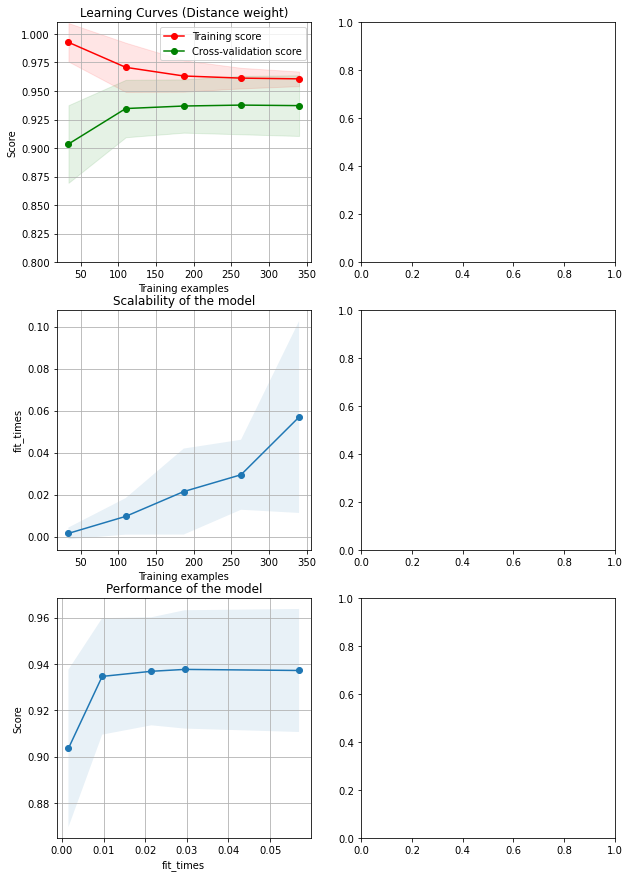

In [8]:
# Learning Curve - Examples
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Distance weight)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = SVC(kernel="linear", gamma="auto",C=0.1)
plot_learning_curve(estimator, title, trainX, trainY, axes=axes[:, 0], ylim=(0.8, 1.01),
                    cv=cv, n_jobs=None)
plt.show()

# Model testing

In [9]:
model = SVC(kernel="linear", gamma="auto",C=0.1)
model.fit(trainX, trainY)

y_predict = model.predict(testX)
print(model.score(testX, testY))

0.9370629370629371


In [10]:
model_cv = SVC(kernel="linear", gamma="auto",C=0.1)
model_cv.fit(trainX, trainY)
y_predict = model_cv.predict(testX)
model_cv_scores = cross_val_score(model_cv, trainX, trainY, cv=5)
print(model_cv_scores.mean())

0.9435841313269494
